In [10]:
import scipy.io
import numpy as np
import pylab as pl

In [11]:
mat = scipy.io.loadmat('data/binaryalphadigs.mat')
data_digits = mat['dat'][:10,]
data_alpha = mat['dat'][10:,]
print("data_digits shape = {}".format(data_digits.shape))
print("data_alpha shape = {}".format(data_alpha.shape))

data_digits shape = (10, 39)
data_alpha shape = (26, 39)


In [12]:
def lire_alpha_digits(data, list_index):
    m, n = data.shape
    p, q = data[0, 0].shape
    matrix = np.zeros((len(list_index)*n, p*q))
    for i, index in enumerate(list_index):
        for j in range(n):
            matrix[i*n + j] = data[index, j].reshape(p*q)
    return matrix

In [13]:
data_alpha_reshaped = lire_alpha_digits(data_alpha, [0])
data_digits_reshaped = lire_alpha_digits(data_digits, [0])

In [14]:
class DbnModel():
    def __init__(self, d: int, q: int, p: int) -> None:
        """
        Initialise un modèle de Deep Belief Network (DBN).

        Args:
            d (int): Nombre de couches RBM dans le DBN.
            q (int): Nombre de neurones dans la couche cachée des RBM.
            p (int): Nombre de neurones dans la couche visible des RBM.
        """
        self.d = d
        self.q = q
        self.p = p
        self.A = np.zeros((d-1, q))
        self.B = np.zeros((d-1, q))
        self.W = np.random.normal(0, 0.1, size=(d-1, q, q))
        self.W0 = np.random.normal(0, 0.1, size=(p, q))
        self.a0 = np.zeros(p)
        self.b0 = np.zeros(q)
    
    def entree_sortie_RBM(self, d: int, H: np.ndarray) -> np.ndarray:
        """
        Calcule l'activation de la couche visible à partir de l'activation de la couche cachée
        pour une RBM spécifique dans le DBN.

        Args:
            d (int): Indice de la RBM.
            H (np.ndarray): Matrice d'activations de la couche cachée.

        Returns:
            np.ndarray: Activation de la couche visible.
        """
        if d != 0:
            A = np.tile(self.A[d-1, :], (H.shape[0], 1))
            Z = np.transpose(self.W[d-1, :, :] @ H.T) + A
            return np.exp(Z)/(1 + np.exp(Z))
        else:
            A = np.tile(self.a0, (H.shape[0], 1))
            Z = np.transpose(self.W0 @ H.T) + A
            return np.exp(Z)/(1 + np.exp(Z))

    def sortie_entree_RBM(self, d: int, V: np.ndarray) -> np.ndarray:
        """
        Calcule l'activation de la couche cachée à partir de l'activation de la couche visible
        pour une RBM spécifique dans le DBN.

        Args:
            d (int): Indice de la RBM.
            V (np.ndarray): Matrice d'activations de la couche visible.

        Returns:
            np.ndarray: Activation de la couche cachée.
        """
        if d != 0:
            B = np.tile(self.B[d-1, :], (V.shape[0], 1))
            Z = np.transpose(self.W[d-1, :, :].T @ V.T) + B
            return np.exp(Z)/(1 + np.exp(Z))
        else:
            B = np.tile(self.b0, (V.shape[0], 1))
            Z = np.transpose(self.W0.T @ V.T) + B
            return np.exp(Z)/(1 + np.exp(Z))
    
    def entree_sortie_DBN(self, H: np.ndarray) -> np.ndarray:
        """
        Calcule l'activation de la couche visible pour l'ensemble du DBN.

        Args:
            H (np.ndarray): Matrice d'activations de la couche cachée.

        Returns:
            np.ndarray: Activation de la couche visible.
        """
        E = H.copy()
        rng = np.random.default_rng()
        for l in range(1, self.d + 1):
            Pe = self.entree_sortie_RBM(self.d - l, E)
            E = rng.binomial(1, Pe, size=Pe.shape)
        return E
    
    def sortie_entree_DBN(self, V: np.ndarray) -> np.ndarray:
        """
        Calcule l'activation de la couche cachée pour l'ensemble du DBN.

        Args:
            V (np.ndarray): Matrice d'activations de la couche visible.

        Returns:
            np.ndarray: Activation de la couche cachée.
        """
        S = V.copy()
        rng = np.random.default_rng()
        for l in range(self.d):
            Ps = self.sortie_entree_RBM(l, S)
            S = rng.binomial(1, Ps, size=Ps.shape)
        return S
    
    def split_in_batches(self, indexes: np.ndarray, batch: int) -> list([np.ndarray]):
        """
        Divise un array d'indices en lots de la taille spécifiée.

        Args:
            indexes (np.ndarray): Vecteur des indices à diviser en lots.
            batch (int): Taille de chaque lot.

        Returns:
            list: Liste des lots d'indices.
        """
        Batches = []
        N = len(indexes) // batch
        for i in range(N):
            Batches.append(indexes[i*batch:i*batch+batch])
        Batches.append(indexes[N*batch:len(indexes)])
        return Batches
    
    def train_RBM(self, t: int, X: np.ndarray, niter: int, step: float, batch: int, verbose: bool = True) -> None:
        """
        Entraîne une RBM spécifique dans le DBN avec les données d'entrée spécifiées.

        Args:
            t (int): Indice de la RBM.
            X (np.ndarray): Données d'entrée pour l'entraînement.
            niter (int): Nombre d'itérations d'entraînement.
            step (float): Taux d'apprentissage.
            batch (int): Taille de lot pour l'entraînement par lot.
            verbose (bool): Affiche ou non les détails de l'entraînement.
        """
        if t != 0:
            assert(X.shape[1] == self.W[t-1, :, :].shape[0]), 'Dimention of input incompatible with parameters of RBM'
        else: 
            assert(X.shape[1]== self.W0.shape[0]), 'Dimention of input incompatible with parameters of RBM'
        batches_index = self.split_in_batches(np.arange(X.shape[0]), batch)
        rng = np.random.default_rng()
        for epoch in range(niter):
            loss = 0
            for batch in batches_index:
                X_batch = X[batch]
                Ph = self.sortie_entree_RBM(t, X_batch)
                H = rng.binomial(1, Ph, size=Ph.shape)
                Pv = self.entree_sortie_RBM(t, H)
                V = rng.binomial(1, Pv, size=Pv.shape)
                Mh = self.sortie_entree_RBM(t, V)
                loss += np.sum((V - X_batch)**2)

                # Compute the gradients
                grad_W = X_batch.T @ Ph - V.T @ Mh
                grad_a = np.sum(X_batch - V, axis=0)
                grad_b = np.sum(Ph - Mh, axis=0)

                # Update the parameters
                if t != 0:
                    self.W[t-1, :, :] += step*grad_W
                    self.A[t-1, :] += step*grad_a
                    self.B[t-1, :] += step*grad_b
                else:
                    self.W0 += step*grad_W
                    self.a0 += step*grad_a
                    self.b0 += step*grad_b
            loss /= X.shape[0]
            if verbose:
                print("Epoch {}/{} : MSE = {}".format(epoch + 1, niter, loss))
    
    def train_DBN(self, X: np.ndarray, niter: int, step: float, batch: int, verbose: bool = True) -> None:
        """
        Entraîne l'ensemble du Deep Belief Network (DBN) avec les données d'entrée spécifiées.

        Args:
            X (np.ndarray): Données d'entrée pour l'entraînement du DBN.
            niter (int): Nombre d'itérations d'entraînement pour chaque RBM.
            step (float): Taux d'apprentissage pour chaque RBM.
            batch (int): Taille de lot pour l'entraînement par lot.
            verbose (bool): Affiche ou non les détails de l'entraînement.
        """
        S = X.copy()
        rng = np.random.default_rng()
        for l in range(self.d):
            self.train_RBM(l, S, niter, step, batch, verbose=False)
            Ps = self.sortie_entree_RBM(l, S)
            S = rng.binomial(1, Ps, size=Ps.shape)
            if verbose:
                print('Training Layer {}/{} ...'.format(l+1, self.d))

    def generer_image_DBN(self, n_images: int, n_iter: int) -> np.ndarray:
        """
        Génère des images à partir du Deep Belief Network (DBN).

        Args:
            n_images (int): Nombre d'images à générer.
            n_iter (int): Nombre d'itérations d'échantillonnage de Gibbs.

        Returns:
            np.ndarray: Matrice d'images générées.
        """
        X = np.random.binomial(1, 0.5, size=(n_images, self.W0.shape[0]))
        S = X.copy()
        rng = np.random.default_rng()
        for _ in range(n_iter):
            Ph = self.sortie_entree_DBN(S)
            H = rng.binomial(1, Ph, size=Ph.shape)
            Pv = self.entree_sortie_DBN(H)
            S = rng.binomial(1, Pv, size=Pv.shape)
        return S


Training Layer 1/2 ...
Training Layer 2/2 ...


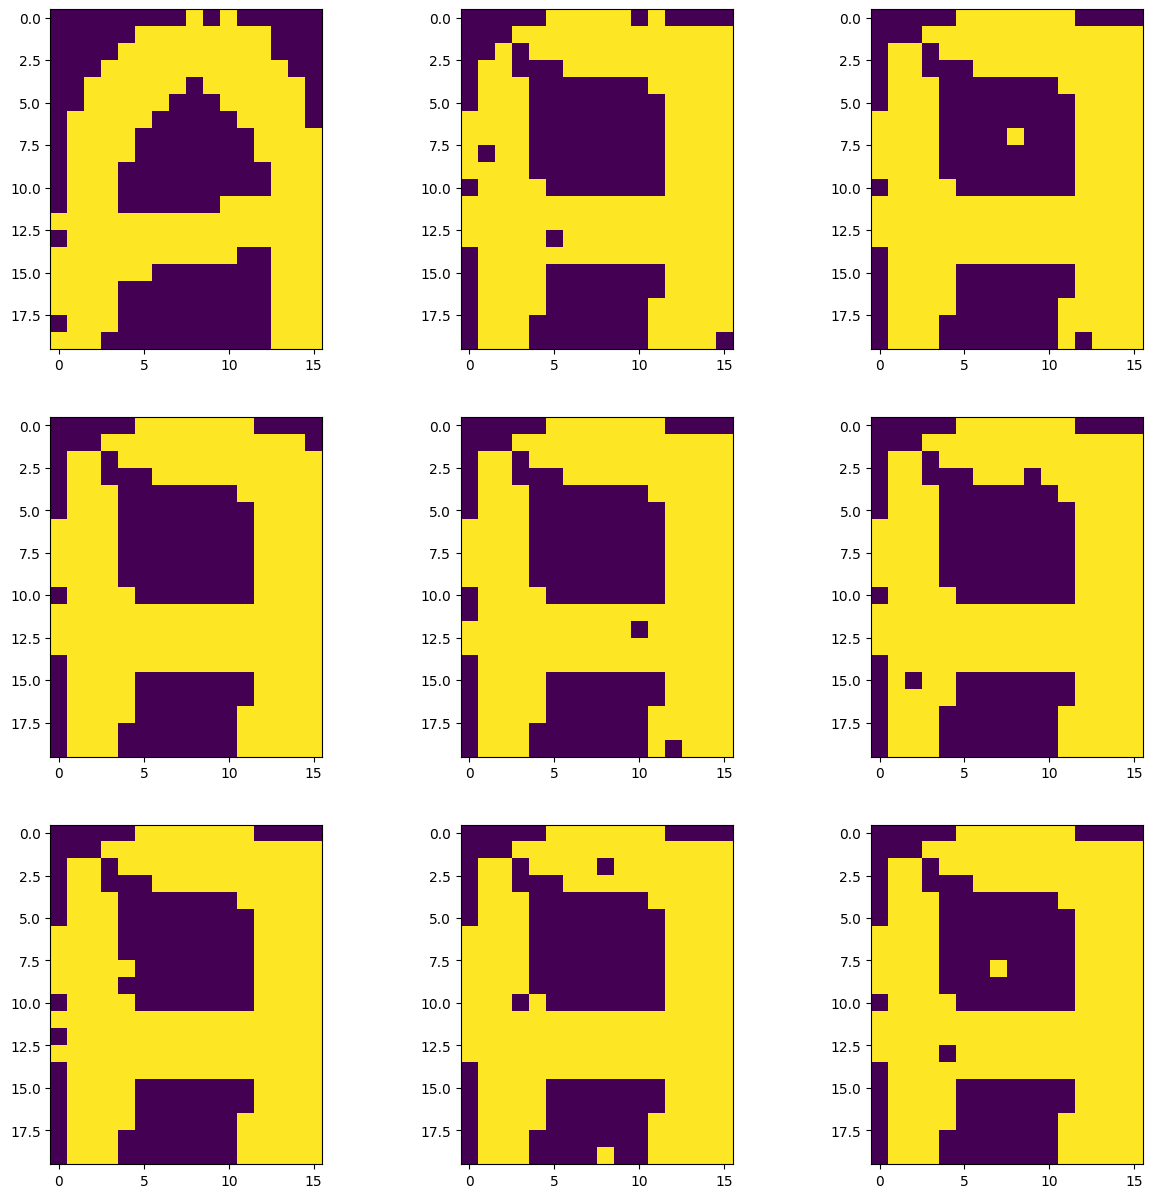

In [15]:
dbn2 = DbnModel(d=2, p=320, q=300)
dbn2.train_DBN(data_alpha_reshaped, 400, 0.01, 10)
gen2 = dbn2.generer_image_DBN(9, 300)

fig, ax = pl.subplots(3, 3, figsize=(15, 15))

for i in range(3):
    for j in range(3):
        ax[i, j].imshow(gen2[3*i + j,:].reshape(20,16))